In [54]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)
df1 = pd.read_csv("labeled_data.csv", index_col=False)
df1.drop(['Unnamed: 0'], axis=1, inplace=True)
df1.sort_index(inplace=True)

df2 = pd.read_csv('hatespeech-train.csv',index_col=False)
df2.drop(['Unnamed: 0'], axis=1, inplace=True)
df_test = pd.read_csv('hatespeech-test.csv',index_col=False)
df_test.drop(['Unnamed: 0'], axis=1, inplace=True)

In [56]:
df= pd.concat([df1.tweet,df2.tweet])
add=[]
for idx, i in enumerate(df):
    for j in df_test.tweet:
        if i==j:
            add.append(idx)
y=pd.concat([df1["class"],df2["class"]])

In [57]:
if add !=[]:
    print("重複データあり")

重複データあり


In [58]:
#除去
df0 = df.iloc[list(set(range(len(df.values)))  - set(add))]
y=  y.iloc[list(set(range(len(df.values)))  - set(add))]

In [59]:
df= df0

In [60]:
df.reset_index(inplace=True,drop=True)
y.reset_index(inplace=True,drop=True)
df_train= pd.concat([df, y],axis=1)

In [61]:
#Nan値除去
df_train= df_train[~df_train.isnull().any(axis=1)]
y= y[~df_train.isnull().any(axis=1)]

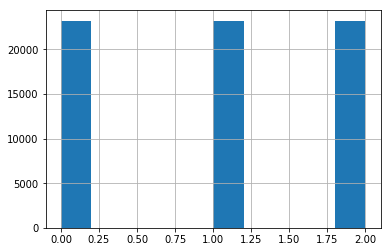

In [62]:
df_train.columns=['text','class']
df_test.columns= ["count","hate_speech","offensive_language","neither","class","text"]
add0= df_train[df_train["class"]==0].sample(20646,replace=True)
add2= df_train[df_train["class"]==2].sample(15825,replace=True)
df_train= pd.concat([df_train,add0,add2])
%matplotlib inline
df_train["class"].hist()

In [63]:
X_test = df_test['text']
Y_test = df_test['class']

X_train,Y_train=df_train['text'],df_train['class']

In [64]:
tweets= pd.concat([X_train,X_test],ignore_index=True)

In [66]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords.extend(["#ff", "ff", "rt"])
stopwords.extend(['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv','becau'])

stemmer = PorterStemmer()


def preprocess(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [67]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [68]:
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} 

In [69]:
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [70]:
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [71]:

pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [72]:
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet)
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]

    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [73]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [74]:
feats = get_feature_array(tweets)

In [75]:
M = np.concatenate([tfidf,pos,feats],axis=1)

In [76]:
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [77]:
#テストデータとトレーニングデータを分離
X_train = pd.DataFrame(M)[:-1040]
y_train = df_train["class"].astype(int)

In [78]:
X_test= pd.DataFrame(M)[-1040:]
y_test = df_test["class"].astype(int)

In [79]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [80]:
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l1", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [81]:
param_grid = [{}] 

In [82]:
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=2)

In [83]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=  58.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  ................................................................
[CV] ................................................. , total=  40.8s
[CV]  ................................................................
[CV] ................................................. , total=  55.6s
[CV]  ................................................................
[CV] ................................................. , total=  43.9s
[CV]  ................................................................
[CV] ................................................. , total=  49.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.6min finished


In [84]:
y_preds = model.predict(X_test)

In [85]:
report = classification_report( y_test, y_preds )

In [86]:
print(report)

              precision    recall  f1-score   support

           0       0.45      0.54      0.49       140
           1       0.87      0.81      0.84       500
           2       0.93      0.94      0.93       400

   micro avg       0.82      0.82      0.82      1040
   macro avg       0.75      0.76      0.75      1040
weighted avg       0.83      0.82      0.83      1040



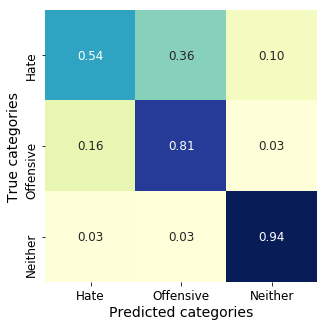

In [87]:
import seaborn
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5, 5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [88]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, y_train)



params = {
        'boosting': 'gbdt',
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric': {'multi_logloss'},
        'num_class': 3,
        'learning_rate': 0.016,
        'num_leaves': 33,
        'min_data_in_leaf': 1,
        'num_iteration': 200,
        'verbose': 0
}


gbm = lgb.train(params,
            lgb_train,
            num_boost_round=200)
y_pred2 = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_light = np.argmax(y_pred2, axis=1)

/Users/kai/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [89]:
report = classification_report( y_test, y_pred_light)

In [90]:
print(report)

              precision    recall  f1-score   support

           0       0.44      0.71      0.54       140
           1       0.91      0.73      0.81       500
           2       0.92      0.95      0.93       400

   micro avg       0.81      0.81      0.81      1040
   macro avg       0.76      0.80      0.76      1040
weighted avg       0.85      0.81      0.82      1040



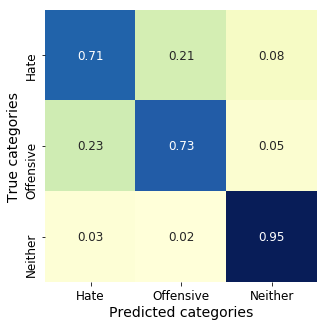

In [91]:
import seaborn
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix( y_test, y_pred_light)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5, 5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)